<a href="https://colab.research.google.com/github/tamotamo17/CZII/blob/main/exp047_3_r05_2_5Dto3D_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jan 30 23:29:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Training base line for [CZII - CryoET Object Identification](https://www.kaggle.com/competitions/czii-cryo-et-object-identification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-dataset-0-5.zip /content
!unzip -q czii-dataset-0-5.zip -d /content
!rm czii-dataset-0-5.zip

!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-cryo-et-object-identification.zip /content
!unzip -q czii-cryo-et-object-identification.zip -d /content
!rm czii-cryo-et-object-identification.zip

CPU times: user 1.11 s, sys: 146 ms, total: 1.26 s
Wall time: 3min 50s


In [ ]:
!pip -q install timm
!pip install -q segmentation_models_pytorch
!pip install natsort cupy-cuda12x==13.3.0
!pip install connected-components-3d

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 12.2.0
    Uninstalling cupy-cuda12x-12.2.0:
      Successfully uninstalled cupy-cuda12x-12.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 12.2 MB/s eta 0:00:00


In [ ]:
DEBUG = False

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/CZII')
import gc
import ast
import json
import cv2
import time
import timm
import pickle
import random
import h5py
from natsort import natsorted
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

from src.utils import set_random_seed, color_labeling, convert_to_rgb, convert_to_8bit, create_animation
from src.losses import criterion_seg
from src.metrics import fbeta_score_multiclass, score, coords_from_segmentation_gpu
from src.datasets import CZII2Dto3DDataset, CZII2Dto3DXYZDataset, CZIIScannerDataset
from src.models import Net, encode_for_resnet, MyUnetDecoder3d
from src.trainer import mixup, train_func, valid_func, inf_func

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp047_3_r05_2.5Dto3D_kernel'
    load_kernel = None
    load_last = True
    targets2idx = {'apo-ferritin': 1,
                   'beta-amylase': 2,
                   'beta-galactosidase': 3,
                   'ribosome': 4,
                   'thyroglobulin': 5,
                   'virus-like-particle': 6
                   }
    idx2targets = {1: 'apo-ferritin',
                   2: 'beta-amylase',
                   3: 'beta-galactosidase',
                   4: 'ribosome',
                   5: 'thyroglobulin',
                   6: 'virus-like-particle'
                   }
    colors = [[0, 117, 220],
              [153, 63, 0],
              [76, 0, 92],
              [ 0, 92, 49],
              [43, 206, 72],
              [255, 204, 153],
              ]
    samples = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
               'TS_69_2', 'TS_99_9', 'TS_6_4'
               ]
    n_folds = 4
    backbone = "resnet34d"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #
    kernel = 5
    padding = 2

    image_size = 630
    crop_size = 192
    indices_ch = np.arange(-32, 32, 1)#[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    in_chans = len(indices_ch)
    direction = 'xy'

    init_lr = 1e-3#1e-3
    eta_min = 1e-7
    batch_size = 4
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 0.75#1.0
    p_rand_order_v1 = 0#0.2
    mid_range = 0
    p_drop_plane = 0.0

    data_dir = '/content/hdf5'
    use_amp = True
    num_workers = 4
    num_targets = len(targets2idx)

    n_epochs = 20
    n_epochs_mixup = n_epochs - 1
    loss_weights = [0.5, 0.5]
    alpha = 0.02
    beta = 0.98
    save_root = '/content/drive/MyDrive/ColabNotebooks/CZII/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:
set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),
    A.RandomCrop(CFG.crop_size, CFG.crop_size, p=1.0)
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    #A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    #A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomCrop(CFG.crop_size, CFG.crop_size, p=1.0)
])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


# DataFrame

In [ ]:
file_paths = glob('/content/hdf5/*')
data_dicts = {}
df = []
for file_path in file_paths:
    print(file_path)
    base = file_path.split('/')[-1].split('.')[0]
    data = {}
    with h5py.File(file_path, 'r') as f:
        data['image'] = f['image'][:]
        data['label'] = f['label'][:]
    data_dicts[base] = data
    # スライス分のインデックス情報を取得
    num_slices = data['image'].shape[0]

    # データフレーム用のリストに情報を追加
    df_ = []
    for i in range(num_slices):
        df_.append({'sample_name': base, 'slice_index': i})
    df_ = pd.DataFrame(df_)
    df.append(df_)
df = pd.concat(df).reset_index(drop=True)
df['source'] = 'denoised'

/content/hdf5/TS_5_4.h5
/content/hdf5/TS_6_6.h5
/content/hdf5/TS_73_6.h5
/content/hdf5/TS_86_3.h5
/content/hdf5/TS_69_2.h5
/content/hdf5/TS_99_9.h5
/content/hdf5/TS_6_4.h5


In [ ]:
experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                'ribosome', 'thyroglobulin', 'virus-like-particle'
                ]

experiments, particle_types = [], []
xs, ys, zs = [], [], []
for experiment_name in experiment_names:
    for target_name in target_names:
        file_path = f'/content/train/overlay/ExperimentRuns/{experiment_name}/Picks/{target_name}.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
        for points in data['points']:
            coords = points['location']
            experiments.append(experiment_name)
            particle_types.append(target_name)
            xs.append(coords['x'])
            ys.append(coords['y'])
            zs.append(coords['z'])
solution = pd.DataFrame({'experiment': experiments,
                          'particle_type': particle_types,
                          'x': xs,
                          'y': ys,
                          'z': zs
                          })
solution


,experiment,particle_type,x,y,z
0,TS_5_4,apo-ferritin,468.514,5915.906,604.167
1,TS_5_4,apo-ferritin,5674.694,1114.354,565.068
2,TS_5_4,apo-ferritin,5744.509,1049.172,653.712
3,TS_5_4,apo-ferritin,5880.769,1125.348,579.560
4,TS_5_4,apo-ferritin,4661.667,1269.497,810.409
...,...,...,...,...,...
1264,TS_6_4,virus-like-particle,5088.704,4120.923,981.513
1265,TS_6_4,virus-like-particle,4268.076,2814.277,815.446
1266,TS_6_4,virus-like-particle,5211.319,5766.513,877.832
1267,TS_6_4,virus-like-particle,4509.570,5139.077,1161.950


In [ ]:
df

,sample_name,slice_index,source
0,TS_5_4,0,denoised
1,TS_5_4,1,denoised
2,TS_5_4,2,denoised
3,TS_5_4,3,denoised
4,TS_5_4,4,denoised
...,...,...,...
1283,TS_6_4,179,denoised
1284,TS_6_4,180,denoised
1285,TS_6_4,181,denoised
1286,TS_6_4,182,denoised


In [ ]:
for key, data in data_dicts.items():
    img = data['image']
    lbl = data['label']
    print(f'{key} image shape: {img.shape}, label shape:{lbl.shape}')
    for i in range(1,7,1):
        print(f'{CFG.idx2targets[i]}: {np.sum(lbl==i)}')
    print('\n')

TS_5_4 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 5201
beta-amylase: 1269
beta-galactosidase: 4617
ribosome: 54794
thyroglobulin: 34548
virus-like-particle: 14177


TS_6_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 4638
beta-amylase: 2014
beta-galactosidase: 4205
ribosome: 40608
thyroglobulin: 40255
virus-like-particle: 24494


TS_73_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 10738
beta-amylase: 1727
beta-galactosidase: 5072
ribosome: 81175
thyroglobulin: 32231
virus-like-particle: 28342


TS_86_3 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 7249
beta-amylase: 1305
beta-galactosidase: 8389
ribosome: 97130
thyroglobulin: 51841
virus-like-particle: 37305


TS_69_2 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 3959
beta-amylase: 1730
beta-galactosidase: 6085
ribosome: 65337
thyroglobulin: 39124
virus-like-particle: 11598


TS_99_9 image shape: (184,

In [ ]:
# sample_id = 'TS_69_2'
# idx_start = 30
# nslice = 5
# offset = 5
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
# lbl = color_labeling(data_dicts[sample_id]['label'])
# concat = np.concatenate([img, lbl], axis=2)
# # plt.figure(figsize=(12,4))
# # for i in range(nslice):
# #     plt.subplot(2, nslice, i+1)
# #     plt.imshow(img[i*offset+idx_start], cmap='gray')
# #     plt.subplot(2, nslice, i+1+nslice)
# #     plt.imshow(lbl[i*offset+idx_start])

# create_animation(concat)

# Dataset

In [ ]:
df['fold'] = -1
for fold, sample_name in enumerate(CFG.samples):
    df.loc[df['sample_name']==sample_name, 'fold'] = fold
df

,sample_name,slice_index,source,fold
0,TS_5_4,0,denoised,0
1,TS_5_4,1,denoised,0
2,TS_5_4,2,denoised,0
3,TS_5_4,3,denoised,0
4,TS_5_4,4,denoised,0
...,...,...,...,...
1283,TS_6_4,179,denoised,6
1284,TS_6_4,180,denoised,6
1285,TS_6_4,181,denoised,6
1286,TS_6_4,182,denoised,6


In [ ]:
rcParams['figure.figsize'] = 20,8
df_show = df
dataset_show = CZII2Dto3DDataset(df_show,
                                 data_dicts,
                                 CFG.indices_ch,
                                 CFG.direction,
                                 'train',
                                 transform=transforms_train
                                 )
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

torch.Size([4, 64, 192, 192]) torch.Size([4, 64, 192, 192])


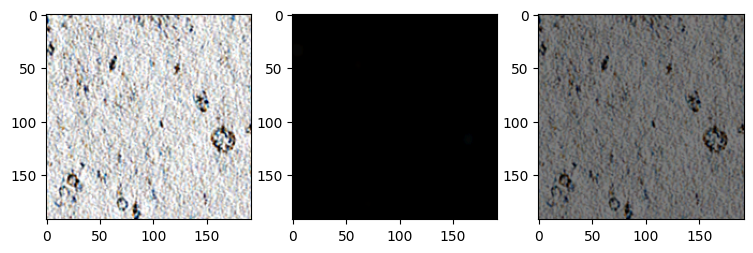

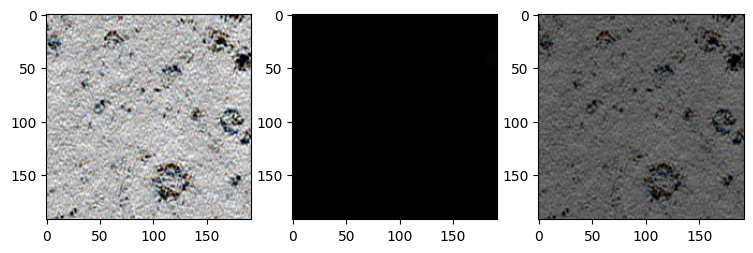

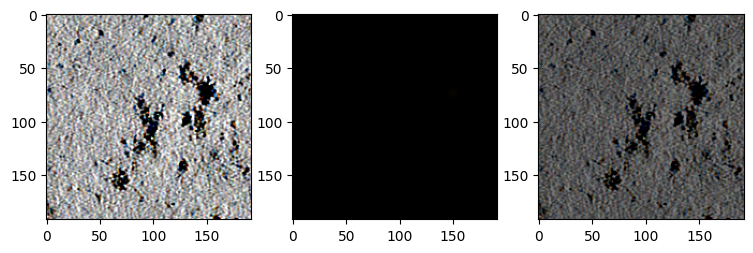

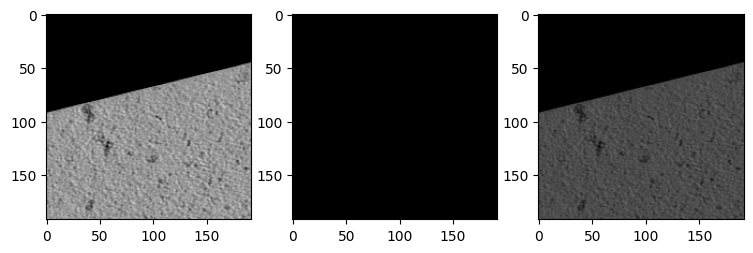

In [ ]:
for data in loader_show:
    imgs = data['image']
    label = data['label']
    for p in range(4):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.subplot(1,3,2)
        plt.imshow(label[p].permute(1, 2, 0)[...,1:4])
        plt.subplot(1,3,3)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.imshow(label[p].permute(1, 2, 0)[...,1:4], alpha=0.5)
    break
print(imgs.shape, label.shape)

In [ ]:
imgs.max(), imgs.min()

(tensor(1.), tensor(0.))

In [ ]:
imgs[p].shape, label[p].shape

(torch.Size([64, 192, 192]), torch.Size([64, 192, 192]))

In [ ]:
torch.unique(label)

tensor([0, 1, 2, 3, 4, 5, 6])

# Model

In [ ]:
m = Net(backbone=CFG.backbone,
        kernel=CFG.kernel,
        padding=CFG.padding,
        pretrained=True,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        )
out = m(imgs)
out.shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([4, 7, 64, 192, 192])

# Loss & Metric

In [ ]:
# criterion_multi(out.to('cpu'), label.to('cpu'),
#                     weights = torch.tensor([1.0, 2.0, 4.0]).to('cpu')
#                     )

# Training

In [ ]:
def run(fold):
    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')
    overlap_size = [16,16,16]
    image_shape = [184, 630, 630]
    crop_size = [64, 192, 192]
    radius = [60, 65, 90, 150, 130, 135]
    areas = [400, 450, 500, 2000, 1500, 1500]
    areas = [area*0.4218 for area in areas] # 0.4218 for [184, 630, 630], 0.0527 for[92, 315, 315], 0.09356 for [92, 420, 420]
    areas_max = [area*15 for area in areas]
    resize_size = [184, 630, 630]#[184, 630, 630]
    maxima_filter_sizes = [7, 7, 7, 11, 11, 11]

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CZII2Dto3DDataset(train_,
                                data_dicts,
                                CFG.indices_ch,
                                CFG.direction,
                                'train', transform=transforms_train
                               )
    dataset_valid = CZIIScannerDataset(valid_,
                                       data_dicts,
                                       crop_size=crop_size,
                                       overlap_size=overlap_size,
                                       image_shape=image_shape,
                                       direction=CFG.direction,
                                       mode='valid',
                                       transform=transforms_valid
                                      )
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = Net(backbone=CFG.backbone,
                    kernel=CFG.kernel,
                    padding=CFG.padding,
                    pretrained=True,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    )
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = -np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer,
                                alpha=CFG.alpha, beta=CFG.beta, loss_weights=CFG.loss_weights,
                                p_mixup=CFG.p_mixup, n_epochs_mixup=CFG.n_epochs_mixup,
                                epoch=epoch, device=device, scaler=scaler
                                )
        # valid_score = valid_func_2dto3d(model, dataset_valid,
        #                                 CFG.direction,
        #                                 crop_size=crop_size,
        #                                 size=image_shape,
        #                                 alpha=CFG.alpha, beta=CFG.beta,
        #                                 loss_weights=CFG.loss_weights,
        #                                 solution=solution
        #                                 )
        gt, outputs, valid_loss, valid_loss_ce, valid_loss_tvs = inf_func_2dto3d(model,
                                                                                 dataset_valid,
                                                                                 CFG.direction,
                                                                                 crop_size=crop_size,
                                                                                 size=image_shape
                                                                                 )
        outputs = outputs.argmax(0)
        experiment_name = experiment_names[fold]
        xs_out, ys_out, zs_out = [], [], []
        for i, (target_name, area, area_max, maxima_filter_size) in enumerate(zip(target_names, areas, areas_max, maxima_filter_sizes)):
            size = 4/3*(np.pi*radius[i]*0.02)**3
            outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                                segmentation_idx=i+1,
                                                maxima_filter_size=maxima_filter_size,#9,
                                                min_particle_size=area,#400,
                                                max_particle_size=area_max,
                                                voxel_spacing_xy=10,#/resize_factor,
                                                voxel_spacing_z=10,
                                                )
            if (i==0):
                if len(outputs_coords_dict)!=0:
                    experiments_out = [experiment_name]*len(outputs_coords_dict)
                    particle_types_out = [target_name]*len(outputs_coords_dict)
                else:
                    experiments_out = []
                    particle_types_out = []
            else:
                if len(outputs_coords_dict)!=0:
                    experiments_out += [experiment_name]*len(outputs_coords_dict)
                    particle_types_out += [target_name]*len(outputs_coords_dict)
            for coords in outputs_coords_dict:
                xs_out.append(coords['x'])
                ys_out.append(coords['y'])
                zs_out.append(coords['z'])
        # break
        submission = pd.DataFrame({'experiment': experiments_out,
                                'particle_type': particle_types_out,
                                'x': xs_out,
                                'y': ys_out,
                                'z': zs_out
                                })

        experiment_names_folds = submission.experiment.unique()
        solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

        score_ = score(solution=solution_fold.reset_index(),
            submission=submission.reset_index(),
            row_id_column_name='id',
            distance_multiplier=1.0,
            beta=4
            )
        metric = score_

        content = (
            f"{time.ctime()} "
            f"Fold {fold}, "
            f"Epoch {epoch}, "
            f"lr: {optimizer.param_groups[0]['lr']:.7f}, "
            f"train loss: {train_loss:.5f}, \n"
            f"metric: {metric:.6f}, "
            f"valid f4: {score_:.4f}, "
        )

        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best

def run_inference_2dto3d(fold, transforms_valid, direction, crop_size, raw_size, size, xflip, yflip, zflip):
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')
    overlap_size = (16,16,16)
    image_shape = raw_size
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_valid = CZIIScannerDataset(valid_,
                                       data_dicts,
                                       crop_size=crop_size,
                                       overlap_size=overlap_size,
                                       image_shape=image_shape,
                                       direction=direction,
                                       mode='valid',
                                       transform=transforms_valid
                                      )
    #loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = Net(backbone=CFG.backbone,
                    kernel=CFG.kernel,
                    padding=CFG.padding,
                    pretrained=True,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    )
    if 'last' in model_file:
        model.load_state_dict(torch.load(model_file)['model_state_dict'])
    else:
        model.load_state_dict(torch.load(model_file, weights_only=True))
    model = model.eval().to(device)
    gts, outputs = inf_func_2dto3d(model, dataset_valid, direction, crop_size, size, xflip, yflip, zflip)
    return gts, outputs

def valid_func_2dto3d(model, dataset, direction, crop_size, size,
                      alpha, beta, loss_weights, solution
                      ):
    experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
    target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                    'ribosome', 'thyroglobulin', 'virus-like-particle'
                    ]
    radius = [60, 65, 90, 150, 130, 135]
    areas = [400, 450, 500, 2000, 1500, 1500]
    areas = [area*0.4218 for area in areas] # 0.4218 for [184, 630, 630], 0.0527 for[92, 315, 315], 0.09356 for [92, 420, 420]
    areas_max = [area*15 for area in areas]
    resize_size = [184, 630, 630]#[184, 630, 630]
    maxima_filter_sizes = [7, 7, 7, 11, 11, 11]

    model.eval()
    gts = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    outputs = torch.zeros([7, 184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    weights = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    bar = tqdm(range(len(dataset)))
    with torch.no_grad():
        with torch.amp.autocast('cuda', enabled=True):
            for j in bar:
                data = dataset[j]
                images = data['image'].unsqueeze(0)
                masks = data['label'].unsqueeze(0)
                z = data['z']#.numpy()
                y = data['y']#.numpy()
                x = data['x']#.numpy()
                images = images.to(device)
                masks = masks.to(device)
                logits = model(images)
                logits = logits.squeeze(0)
                masks = masks.squeeze(0)
                if direction=='yz':
                    logits = logits.permute(0,2,3,1)
                    masks = masks.permute(1,2,0)
                elif direction=='zx':
                    logits = logits.permute(0,2,1,3)
                    masks = masks.permute(1,0,2)
                loss, loss_bce, loss_tvs = 0,0,0#criterion_seg(logits, masks)
                outputs[:,z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += logits
                gts[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] = masks.to(float)
                weights[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += 1
                #break
    #outputs = outputs.permute(1, 0, 2, 3)  # [channels, depth, height, width]
    outputs /= weights
    channels, depth, height, width = outputs.shape
    print(outputs.shape)
    # リサイズのために形状を変更
    #outputs = outputs.reshape(channels * depth, 1, height, width)  # [channels * depth, 1, height, width]
    outputs = F.interpolate(outputs.unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0)  # [channels * depth, 1, new_height, new_width]
    gts = F.interpolate(gts.unsqueeze(0).unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0).squeeze(0)
    #gts = gts.to(torch.long)
    print(outputs.shape, gts.shape)
    #loss_seg, loss_bce_seg, loss_tvs_seg = criterion_seg(outputs.unsqueeze(0), gts.unsqueeze(0), alpha, beta, loss_weights)

    outputs = outputs.cpu()
    gts = gts.cpu()
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    xs_out, ys_out, zs_out = [], [], []
    for i, (target_name, area, area_max, maxima_filter_size) in enumerate(zip(target_names, areas, areas_max, maxima_filter_sizes)):
        size = 4/3*(np.pi*radius[i]*0.02)**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=maxima_filter_size,#9,
                                               min_particle_size=area,#400,
                                               max_particle_size=area_max,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
            else:
                experiments_out = []
                particle_types_out = []
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break
    submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

    experiment_names_folds = submission.experiment.unique()
    solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

    score_ = score(solution=solution_fold.reset_index(),
        submission=submission.reset_index(),
        row_id_column_name='id',
        distance_multiplier=1.0,
        beta=4
        )
    return score_

def inf_func_2dto3d(model, dataset, direction, crop_size, size, xflip=False, yflip=False, zflip=False):
    model.eval()
    gts = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    outputs = torch.zeros([7, 184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    weights = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    bar = tqdm(range(len(dataset)))
    valid_loss, valid_loss_bce, valid_loss_tvs = [], [], []
    with torch.no_grad():
        with torch.amp.autocast('cuda', enabled=True):
            for j in bar:
                cnt = 1
                data = dataset[j]
                images = data['image'].unsqueeze(0)
                masks = data['label'].unsqueeze(0)
                z = data['z']#.numpy()
                y = data['y']#.numpy()
                x = data['x']#.numpy()
                images = images.to(device)
                masks = masks.to(device)
                logits = model(images)
                if xflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[3])), dims=[4])
                    logits += logits_tta
                    cnt += 1
                if yflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[2])), dims=[3])
                    logits += logits_tta
                    cnt += 1
                if zflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[1])), dims=[2])
                    logits += logits_tta
                    cnt += 1
                logits /= cnt
                logits = logits.squeeze(0)
                masks = masks.squeeze(0)
                if direction=='yz':
                    logits = logits.permute(0,2,3,1)
                    masks = masks.permute(1,2,0)
                elif direction=='zx':
                    logits = logits.permute(0,2,1,3)
                    masks = masks.permute(1,0,2)
                #print(logits.shape, masks.shape)
                loss, loss_bce, loss_tvs = 0, 0, 0#criterion_seg(logits.unsqueeze(0), masks.unsqueeze(0), CFG.alpha, CFG.beta, CFG.loss_weights)
                valid_loss.append(loss)
                valid_loss_bce.append(loss_bce)
                valid_loss_tvs.append(loss_tvs)
                outputs[:,z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += logits
                gts[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] = masks#.to(dtype=torch.long)
                weights[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += 1
    #outputs = outputs.permute(1, 0, 2, 3)  # [channels, depth, height, width]
    outputs /= weights
    channels, depth, height, width = outputs.shape
    # リサイズのために形状を変更
    #outputs = outputs.reshape(channels * depth, 1, height, width)  # [channels * depth, 1, height, width]
    outputs = F.interpolate(outputs.unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0)  # [channels * depth, 1, new_height, new_width]
    gts = F.interpolate(gts.unsqueeze(0).unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0).squeeze(0)
    outputs = outputs.cpu()
    gts = gts.cpu()
    return gts, outputs, np.mean(valid_loss), np.mean(valid_loss_bce), np.mean(valid_loss_tvs)

In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [0, 1, 2]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 02:13:03 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:07<00:00,  8.54it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 02:19:41 2025 Fold 0, Epoch 1, lr: 0.0010000, train loss: 0.33088, 
metric: 0.463084, valid f4: 0.4631, 
metric_best (-inf --> 0.463084). Saving model ...
Fri Jan 31 02:19:42 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 02:25:59 2025 Fold 0, Epoch 2, lr: 0.0009938, train loss: 0.19971, 
metric: 0.658726, valid f4: 0.6587, 
metric_best (0.463084 --> 0.658726). Saving model ...
Fri Jan 31 02:26:00 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 02:32:16 2025 Fold 0, Epoch 3, lr: 0.0009755, train loss: 0.16557, 
metric: 0.731769, valid f4: 0.7318, 
metric_best (0.658726 --> 0.731769). Saving model ...
Fri Jan 31 02:32:18 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 02:38:32 2025 Fold 0, Epoch 4, lr: 0.0009455, train loss: 0.15928, 
metric: 0.824615, valid f4: 0.8246, 
metric_best (0.731769 --> 0.824615). Saving model ...
Fri Jan 31 02:38:34 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 02:44:46 2025 Fold 0, Epoch 5, lr: 0.0009045, train loss: 0.14889, 
metric: 0.816496, valid f4: 0.8165, 
Fri Jan 31 02:44:47 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 02:51:01 2025 Fold 0, Epoch 6, lr: 0.0008536, train loss: 0.14059, 
metric: 0.795354, valid f4: 0.7954, 
Fri Jan 31 02:51:02 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 02:57:16 2025 Fold 0, Epoch 7, lr: 0.0007939, train loss: 0.14025, 
metric: 0.760025, valid f4: 0.7600, 
Fri Jan 31 02:57:17 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 03:03:32 2025 Fold 0, Epoch 8, lr: 0.0007270, train loss: 0.14040, 
metric: 0.834715, valid f4: 0.8347, 
metric_best (0.824615 --> 0.834715). Saving model ...
Fri Jan 31 03:03:33 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 03:09:49 2025 Fold 0, Epoch 9, lr: 0.0006545, train loss: 0.13533, 
metric: 0.780444, valid f4: 0.7804, 
Fri Jan 31 03:09:50 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 03:16:06 2025 Fold 0, Epoch 10, lr: 0.0005783, train loss: 0.12748, 
metric: 0.870965, valid f4: 0.8710, 
metric_best (0.834715 --> 0.870965). Saving model ...
Fri Jan 31 03:16:08 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 03:22:24 2025 Fold 0, Epoch 11, lr: 0.0005000, train loss: 0.12428, 
metric: 0.792557, valid f4: 0.7926, 
Fri Jan 31 03:22:24 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 03:28:39 2025 Fold 0, Epoch 12, lr: 0.0004218, train loss: 0.13225, 
metric: 0.787875, valid f4: 0.7879, 
Fri Jan 31 03:28:40 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 03:34:56 2025 Fold 0, Epoch 13, lr: 0.0003456, train loss: 0.12429, 
metric: 0.715487, valid f4: 0.7155, 
Fri Jan 31 03:34:57 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 03:41:13 2025 Fold 0, Epoch 14, lr: 0.0002731, train loss: 0.11681, 
metric: 0.839920, valid f4: 0.8399, 
Fri Jan 31 03:41:14 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 03:47:31 2025 Fold 0, Epoch 15, lr: 0.0002062, train loss: 0.11932, 
metric: 0.794356, valid f4: 0.7944, 
Fri Jan 31 03:47:31 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 03:53:47 2025 Fold 0, Epoch 16, lr: 0.0001465, train loss: 0.12051, 
metric: 0.774456, valid f4: 0.7745, 
Fri Jan 31 03:53:48 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 04:00:02 2025 Fold 0, Epoch 17, lr: 0.0000956, train loss: 0.11638, 
metric: 0.784434, valid f4: 0.7844, 
Fri Jan 31 04:00:03 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 04:06:19 2025 Fold 0, Epoch 18, lr: 0.0000546, train loss: 0.11584, 
metric: 0.766277, valid f4: 0.7663, 
Fri Jan 31 04:06:20 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 04:12:23 2025 Fold 0, Epoch 19, lr: 0.0000246, train loss: 0.08208, 
metric: 0.773683, valid f4: 0.7737, 
Fri Jan 31 04:12:24 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 04:18:24 2025 Fold 0, Epoch 20, lr: 0.0000063, train loss: 0.07867, 
metric: 0.772365, valid f4: 0.7724, 


<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 04:18:26 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.50it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 04:24:36 2025 Fold 1, Epoch 1, lr: 0.0010000, train loss: 0.34307, 
metric: 0.218814, valid f4: 0.2188, 
metric_best (-inf --> 0.218814). Saving model ...
Fri Jan 31 04:24:37 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 04:30:53 2025 Fold 1, Epoch 2, lr: 0.0009938, train loss: 0.21260, 
metric: 0.538872, valid f4: 0.5389, 
metric_best (0.218814 --> 0.538872). Saving model ...
Fri Jan 31 04:30:55 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 04:37:09 2025 Fold 1, Epoch 3, lr: 0.0009755, train loss: 0.18114, 
metric: 0.810802, valid f4: 0.8108, 
metric_best (0.538872 --> 0.810802). Saving model ...
Fri Jan 31 04:37:10 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 04:43:24 2025 Fold 1, Epoch 4, lr: 0.0009455, train loss: 0.16614, 
metric: 0.757815, valid f4: 0.7578, 
Fri Jan 31 04:43:25 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 04:49:39 2025 Fold 1, Epoch 5, lr: 0.0009045, train loss: 0.15397, 
metric: 0.809319, valid f4: 0.8093, 
Fri Jan 31 04:49:40 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 04:55:54 2025 Fold 1, Epoch 6, lr: 0.0008536, train loss: 0.14944, 
metric: 0.767147, valid f4: 0.7671, 
Fri Jan 31 04:55:54 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 05:02:06 2025 Fold 1, Epoch 7, lr: 0.0007939, train loss: 0.13994, 
metric: 0.741888, valid f4: 0.7419, 
Fri Jan 31 05:02:07 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.48it/s]


No segmentation with label 2 found.
Fri Jan 31 05:08:24 2025 Fold 1, Epoch 8, lr: 0.0007270, train loss: 0.13792, 
metric: 0.836334, valid f4: 0.8363, 
metric_best (0.810802 --> 0.836334). Saving model ...
Fri Jan 31 05:08:25 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.74it/s]


No segmentation with label 2 found.
Fri Jan 31 05:14:30 2025 Fold 1, Epoch 9, lr: 0.0006545, train loss: 0.14051, 
metric: 0.822312, valid f4: 0.8223, 
Fri Jan 31 05:14:31 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.73it/s]


No segmentation with label 2 found.
Fri Jan 31 05:20:34 2025 Fold 1, Epoch 10, lr: 0.0005783, train loss: 0.13283, 
metric: 0.780206, valid f4: 0.7802, 
Fri Jan 31 05:20:35 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.77it/s]


No segmentation with label 2 found.
Fri Jan 31 05:26:40 2025 Fold 1, Epoch 11, lr: 0.0005000, train loss: 0.13132, 
metric: 0.810457, valid f4: 0.8105, 
Fri Jan 31 05:26:41 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 05:32:53 2025 Fold 1, Epoch 12, lr: 0.0004218, train loss: 0.13004, 
metric: 0.819199, valid f4: 0.8192, 
Fri Jan 31 05:32:54 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 05:39:08 2025 Fold 1, Epoch 13, lr: 0.0003456, train loss: 0.12380, 
metric: 0.856261, valid f4: 0.8563, 
metric_best (0.836334 --> 0.856261). Saving model ...
Fri Jan 31 05:39:10 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 05:45:23 2025 Fold 1, Epoch 14, lr: 0.0002731, train loss: 0.11959, 
metric: 0.863458, valid f4: 0.8635, 
metric_best (0.856261 --> 0.863458). Saving model ...
Fri Jan 31 05:45:25 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 05:51:39 2025 Fold 1, Epoch 15, lr: 0.0002062, train loss: 0.11764, 
metric: 0.857023, valid f4: 0.8570, 
Fri Jan 31 05:51:40 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 05:57:54 2025 Fold 1, Epoch 16, lr: 0.0001465, train loss: 0.11574, 
metric: 0.883091, valid f4: 0.8831, 
metric_best (0.863458 --> 0.883091). Saving model ...
Fri Jan 31 05:57:56 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.35it/s]


No segmentation with label 2 found.
Fri Jan 31 06:04:11 2025 Fold 1, Epoch 17, lr: 0.0000956, train loss: 0.11384, 
metric: 0.837367, valid f4: 0.8374, 
Fri Jan 31 06:04:12 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 06:10:31 2025 Fold 1, Epoch 18, lr: 0.0000546, train loss: 0.11413, 
metric: 0.847716, valid f4: 0.8477, 
Fri Jan 31 06:10:32 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 06:16:39 2025 Fold 1, Epoch 19, lr: 0.0000246, train loss: 0.07998, 
metric: 0.850098, valid f4: 0.8501, 
Fri Jan 31 06:16:40 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 06:22:48 2025 Fold 1, Epoch 20, lr: 0.0000063, train loss: 0.07997, 
metric: 0.857144, valid f4: 0.8571, 


<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 06:22:50 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 06:29:06 2025 Fold 2, Epoch 1, lr: 0.0010000, train loss: 0.33807, 
metric: 0.386202, valid f4: 0.3862, 
metric_best (-inf --> 0.386202). Saving model ...
Fri Jan 31 06:29:07 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.38it/s]


No segmentation with label 2 found.
Fri Jan 31 06:35:23 2025 Fold 2, Epoch 2, lr: 0.0009938, train loss: 0.19821, 
metric: 0.695372, valid f4: 0.6954, 
metric_best (0.386202 --> 0.695372). Saving model ...
Fri Jan 31 06:35:25 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 06:41:40 2025 Fold 2, Epoch 3, lr: 0.0009755, train loss: 0.16841, 
metric: 0.612518, valid f4: 0.6125, 
Fri Jan 31 06:41:41 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 06:47:56 2025 Fold 2, Epoch 4, lr: 0.0009455, train loss: 0.15843, 
metric: 0.775412, valid f4: 0.7754, 
metric_best (0.695372 --> 0.775412). Saving model ...
Fri Jan 31 06:47:57 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 06:54:11 2025 Fold 2, Epoch 5, lr: 0.0009045, train loss: 0.14506, 
metric: 0.796233, valid f4: 0.7962, 
metric_best (0.775412 --> 0.796233). Saving model ...
Fri Jan 31 06:54:13 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 07:00:27 2025 Fold 2, Epoch 6, lr: 0.0008536, train loss: 0.14404, 
metric: 0.778382, valid f4: 0.7784, 
Fri Jan 31 07:00:28 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 07:06:42 2025 Fold 2, Epoch 7, lr: 0.0007939, train loss: 0.13905, 
metric: 0.785819, valid f4: 0.7858, 
Fri Jan 31 07:06:43 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 07:13:00 2025 Fold 2, Epoch 8, lr: 0.0007270, train loss: 0.13200, 
metric: 0.754199, valid f4: 0.7542, 
Fri Jan 31 07:13:01 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 07:19:19 2025 Fold 2, Epoch 9, lr: 0.0006545, train loss: 0.12980, 
metric: 0.806238, valid f4: 0.8062, 
metric_best (0.796233 --> 0.806238). Saving model ...
Fri Jan 31 07:19:21 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 07:25:41 2025 Fold 2, Epoch 10, lr: 0.0005783, train loss: 0.13117, 
metric: 0.730376, valid f4: 0.7304, 
Fri Jan 31 07:25:42 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 07:31:58 2025 Fold 2, Epoch 11, lr: 0.0005000, train loss: 0.12826, 
metric: 0.801859, valid f4: 0.8019, 
Fri Jan 31 07:31:59 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 07:38:11 2025 Fold 2, Epoch 12, lr: 0.0004218, train loss: 0.12452, 
metric: 0.817351, valid f4: 0.8174, 
metric_best (0.806238 --> 0.817351). Saving model ...
Fri Jan 31 07:38:12 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 07:44:31 2025 Fold 2, Epoch 13, lr: 0.0003456, train loss: 0.12531, 
metric: 0.820714, valid f4: 0.8207, 
metric_best (0.817351 --> 0.820714). Saving model ...
Fri Jan 31 07:44:32 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 07:50:47 2025 Fold 2, Epoch 14, lr: 0.0002731, train loss: 0.11406, 
metric: 0.803406, valid f4: 0.8034, 
Fri Jan 31 07:50:48 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 07:57:03 2025 Fold 2, Epoch 15, lr: 0.0002062, train loss: 0.11547, 
metric: 0.806773, valid f4: 0.8068, 
Fri Jan 31 07:57:04 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 08:03:16 2025 Fold 2, Epoch 16, lr: 0.0001465, train loss: 0.11675, 
metric: 0.779389, valid f4: 0.7794, 
Fri Jan 31 08:03:17 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 08:09:33 2025 Fold 2, Epoch 17, lr: 0.0000956, train loss: 0.11493, 
metric: 0.803216, valid f4: 0.8032, 
Fri Jan 31 08:09:34 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 08:15:47 2025 Fold 2, Epoch 18, lr: 0.0000546, train loss: 0.11338, 
metric: 0.831421, valid f4: 0.8314, 
metric_best (0.820714 --> 0.831421). Saving model ...
Fri Jan 31 08:15:48 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 08:21:59 2025 Fold 2, Epoch 19, lr: 0.0000246, train loss: 0.08027, 
metric: 0.817889, valid f4: 0.8179, 
Fri Jan 31 08:22:00 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 08:28:14 2025 Fold 2, Epoch 20, lr: 0.0000063, train loss: 0.07522, 
metric: 0.824315, valid f4: 0.8243, 
[0.870965417513795, 0.8830910563412263, 0.8314209114160552]
0.8618257950903588


In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [3, 4, 5, 6]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 08:29:19 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 08:35:29 2025 Fold 3, Epoch 1, lr: 0.0010000, train loss: 0.34509, 
metric: 0.409705, valid f4: 0.4097, 
metric_best (-inf --> 0.409705). Saving model ...
Fri Jan 31 08:35:30 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.29it/s]


No segmentation with label 2 found.
Fri Jan 31 08:41:48 2025 Fold 3, Epoch 2, lr: 0.0009938, train loss: 0.23864, 
metric: 0.466470, valid f4: 0.4665, 
metric_best (0.409705 --> 0.466470). Saving model ...
Fri Jan 31 08:41:49 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 08:48:08 2025 Fold 3, Epoch 3, lr: 0.0009755, train loss: 0.18231, 
metric: 0.672350, valid f4: 0.6724, 
metric_best (0.466470 --> 0.672350). Saving model ...
Fri Jan 31 08:48:10 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 08:54:22 2025 Fold 3, Epoch 4, lr: 0.0009455, train loss: 0.15918, 
metric: 0.669697, valid f4: 0.6697, 
Fri Jan 31 08:54:23 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.38it/s]


No segmentation with label 2 found.
Fri Jan 31 09:00:40 2025 Fold 3, Epoch 5, lr: 0.0009045, train loss: 0.15540, 
metric: 0.758505, valid f4: 0.7585, 
metric_best (0.672350 --> 0.758505). Saving model ...
Fri Jan 31 09:00:41 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 09:06:53 2025 Fold 3, Epoch 6, lr: 0.0008536, train loss: 0.14526, 
metric: 0.666312, valid f4: 0.6663, 
Fri Jan 31 09:06:54 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.38it/s]


No segmentation with label 2 found.
Fri Jan 31 09:13:06 2025 Fold 3, Epoch 7, lr: 0.0007939, train loss: 0.13866, 
metric: 0.670680, valid f4: 0.6707, 
Fri Jan 31 09:13:07 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 09:19:20 2025 Fold 3, Epoch 8, lr: 0.0007270, train loss: 0.14297, 
metric: 0.815409, valid f4: 0.8154, 
metric_best (0.758505 --> 0.815409). Saving model ...
Fri Jan 31 09:19:22 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 09:25:36 2025 Fold 3, Epoch 9, lr: 0.0006545, train loss: 0.13537, 
metric: 0.775262, valid f4: 0.7753, 
Fri Jan 31 09:25:37 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.38it/s]


No segmentation with label 2 found.
Fri Jan 31 09:31:49 2025 Fold 3, Epoch 10, lr: 0.0005783, train loss: 0.12620, 
metric: 0.757103, valid f4: 0.7571, 
Fri Jan 31 09:31:50 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 09:38:06 2025 Fold 3, Epoch 11, lr: 0.0005000, train loss: 0.12877, 
metric: 0.772044, valid f4: 0.7720, 
Fri Jan 31 09:38:07 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 09:44:25 2025 Fold 3, Epoch 12, lr: 0.0004218, train loss: 0.12820, 
metric: 0.786739, valid f4: 0.7867, 
Fri Jan 31 09:44:25 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 09:50:40 2025 Fold 3, Epoch 13, lr: 0.0003456, train loss: 0.12345, 
metric: 0.827555, valid f4: 0.8276, 
metric_best (0.815409 --> 0.827555). Saving model ...
Fri Jan 31 09:50:42 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 09:56:55 2025 Fold 3, Epoch 14, lr: 0.0002731, train loss: 0.11734, 
metric: 0.811469, valid f4: 0.8115, 
Fri Jan 31 09:56:56 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 10:03:08 2025 Fold 3, Epoch 15, lr: 0.0002062, train loss: 0.11652, 
metric: 0.811647, valid f4: 0.8116, 
Fri Jan 31 10:03:09 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 10:09:24 2025 Fold 3, Epoch 16, lr: 0.0001465, train loss: 0.11653, 
metric: 0.762337, valid f4: 0.7623, 
Fri Jan 31 10:09:25 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 10:15:39 2025 Fold 3, Epoch 17, lr: 0.0000956, train loss: 0.11327, 
metric: 0.819083, valid f4: 0.8191, 
Fri Jan 31 10:15:40 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 10:21:53 2025 Fold 3, Epoch 18, lr: 0.0000546, train loss: 0.11298, 
metric: 0.821803, valid f4: 0.8218, 
Fri Jan 31 10:21:54 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 10:27:59 2025 Fold 3, Epoch 19, lr: 0.0000246, train loss: 0.07641, 
metric: 0.821633, valid f4: 0.8216, 
Fri Jan 31 10:28:00 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.38it/s]


No segmentation with label 2 found.
Fri Jan 31 10:34:03 2025 Fold 3, Epoch 20, lr: 0.0000063, train loss: 0.07540, 
metric: 0.792370, valid f4: 0.7924, 


<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 10:34:06 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 10:40:13 2025 Fold 4, Epoch 1, lr: 0.0010000, train loss: 0.35368, 
metric: 0.495238, valid f4: 0.4952, 
metric_best (-inf --> 0.495238). Saving model ...
Fri Jan 31 10:40:14 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 10:46:30 2025 Fold 4, Epoch 2, lr: 0.0009938, train loss: 0.20416, 
metric: 0.749266, valid f4: 0.7493, 
metric_best (0.495238 --> 0.749266). Saving model ...
Fri Jan 31 10:46:31 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 10:52:46 2025 Fold 4, Epoch 3, lr: 0.0009755, train loss: 0.16607, 
metric: 0.757286, valid f4: 0.7573, 
metric_best (0.749266 --> 0.757286). Saving model ...
Fri Jan 31 10:52:47 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 10:59:00 2025 Fold 4, Epoch 4, lr: 0.0009455, train loss: 0.15516, 
metric: 0.843087, valid f4: 0.8431, 
metric_best (0.757286 --> 0.843087). Saving model ...
Fri Jan 31 10:59:02 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 11:05:16 2025 Fold 4, Epoch 5, lr: 0.0009045, train loss: 0.14981, 
metric: 0.841076, valid f4: 0.8411, 
Fri Jan 31 11:05:17 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 11:11:30 2025 Fold 4, Epoch 6, lr: 0.0008536, train loss: 0.14233, 
metric: 0.577214, valid f4: 0.5772, 
Fri Jan 31 11:11:31 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 11:17:47 2025 Fold 4, Epoch 7, lr: 0.0007939, train loss: 0.14175, 
metric: 0.854215, valid f4: 0.8542, 
metric_best (0.843087 --> 0.854215). Saving model ...
Fri Jan 31 11:17:49 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 11:24:05 2025 Fold 4, Epoch 8, lr: 0.0007270, train loss: 0.13851, 
metric: 0.838758, valid f4: 0.8388, 
Fri Jan 31 11:24:06 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 11:30:22 2025 Fold 4, Epoch 9, lr: 0.0006545, train loss: 0.13693, 
metric: 0.871589, valid f4: 0.8716, 
metric_best (0.854215 --> 0.871589). Saving model ...
Fri Jan 31 11:30:23 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 11:36:36 2025 Fold 4, Epoch 10, lr: 0.0005783, train loss: 0.12653, 
metric: 0.819779, valid f4: 0.8198, 
Fri Jan 31 11:36:37 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 11:42:53 2025 Fold 4, Epoch 11, lr: 0.0005000, train loss: 0.13161, 
metric: 0.775239, valid f4: 0.7752, 
Fri Jan 31 11:42:54 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 11:49:08 2025 Fold 4, Epoch 12, lr: 0.0004218, train loss: 0.12637, 
metric: 0.830583, valid f4: 0.8306, 
Fri Jan 31 11:49:09 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.46it/s]


No segmentation with label 2 found.
Fri Jan 31 11:55:24 2025 Fold 4, Epoch 13, lr: 0.0003456, train loss: 0.12611, 
metric: 0.855272, valid f4: 0.8553, 
Fri Jan 31 11:55:25 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 12:01:40 2025 Fold 4, Epoch 14, lr: 0.0002731, train loss: 0.12131, 
metric: 0.868699, valid f4: 0.8687, 
Fri Jan 31 12:01:41 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 12:07:58 2025 Fold 4, Epoch 15, lr: 0.0002062, train loss: 0.11700, 
metric: 0.863498, valid f4: 0.8635, 
Fri Jan 31 12:07:59 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 12:14:17 2025 Fold 4, Epoch 16, lr: 0.0001465, train loss: 0.11430, 
metric: 0.857902, valid f4: 0.8579, 
Fri Jan 31 12:14:18 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 12:20:36 2025 Fold 4, Epoch 17, lr: 0.0000956, train loss: 0.11545, 
metric: 0.857103, valid f4: 0.8571, 
Fri Jan 31 12:20:37 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 12:26:53 2025 Fold 4, Epoch 18, lr: 0.0000546, train loss: 0.11572, 
metric: 0.849274, valid f4: 0.8493, 
Fri Jan 31 12:26:54 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 12:32:59 2025 Fold 4, Epoch 19, lr: 0.0000246, train loss: 0.07817, 
metric: 0.837333, valid f4: 0.8373, 
Fri Jan 31 12:33:00 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 12:39:07 2025 Fold 4, Epoch 20, lr: 0.0000063, train loss: 0.07928, 
metric: 0.826087, valid f4: 0.8261, 


<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 12:39:09 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 12:45:20 2025 Fold 5, Epoch 1, lr: 0.0010000, train loss: 0.34569, 
metric: 0.425596, valid f4: 0.4256, 
metric_best (-inf --> 0.425596). Saving model ...
Fri Jan 31 12:45:21 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 12:51:37 2025 Fold 5, Epoch 2, lr: 0.0009938, train loss: 0.22752, 
metric: 0.616861, valid f4: 0.6169, 
metric_best (0.425596 --> 0.616861). Saving model ...
Fri Jan 31 12:51:38 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 12:57:53 2025 Fold 5, Epoch 3, lr: 0.0009755, train loss: 0.17299, 
metric: 0.785864, valid f4: 0.7859, 
metric_best (0.616861 --> 0.785864). Saving model ...
Fri Jan 31 12:57:54 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 13:04:08 2025 Fold 5, Epoch 4, lr: 0.0009455, train loss: 0.16064, 
metric: 0.679003, valid f4: 0.6790, 
Fri Jan 31 13:04:09 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 13:10:23 2025 Fold 5, Epoch 5, lr: 0.0009045, train loss: 0.15110, 
metric: 0.810714, valid f4: 0.8107, 
metric_best (0.785864 --> 0.810714). Saving model ...
Fri Jan 31 13:10:25 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 13:16:38 2025 Fold 5, Epoch 6, lr: 0.0008536, train loss: 0.14531, 
metric: 0.773074, valid f4: 0.7731, 
Fri Jan 31 13:16:39 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 13:22:53 2025 Fold 5, Epoch 7, lr: 0.0007939, train loss: 0.14234, 
metric: 0.766325, valid f4: 0.7663, 
Fri Jan 31 13:22:54 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 13:29:07 2025 Fold 5, Epoch 8, lr: 0.0007270, train loss: 0.13542, 
metric: 0.804211, valid f4: 0.8042, 
Fri Jan 31 13:29:08 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 13:35:23 2025 Fold 5, Epoch 9, lr: 0.0006545, train loss: 0.13523, 
metric: 0.793943, valid f4: 0.7939, 
Fri Jan 31 13:35:24 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 13:41:39 2025 Fold 5, Epoch 10, lr: 0.0005783, train loss: 0.13553, 
metric: 0.814219, valid f4: 0.8142, 
metric_best (0.810714 --> 0.814219). Saving model ...
Fri Jan 31 13:41:40 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 13:47:55 2025 Fold 5, Epoch 11, lr: 0.0005000, train loss: 0.12465, 
metric: 0.787726, valid f4: 0.7877, 
Fri Jan 31 13:47:56 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 13:54:11 2025 Fold 5, Epoch 12, lr: 0.0004218, train loss: 0.12356, 
metric: 0.786780, valid f4: 0.7868, 
Fri Jan 31 13:54:12 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 14:00:25 2025 Fold 5, Epoch 13, lr: 0.0003456, train loss: 0.11853, 
metric: 0.797541, valid f4: 0.7975, 
Fri Jan 31 14:00:26 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.39it/s]


No segmentation with label 2 found.
Fri Jan 31 14:06:40 2025 Fold 5, Epoch 14, lr: 0.0002731, train loss: 0.11763, 
metric: 0.779611, valid f4: 0.7796, 
Fri Jan 31 14:06:41 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 14:12:55 2025 Fold 5, Epoch 15, lr: 0.0002062, train loss: 0.11499, 
metric: 0.793596, valid f4: 0.7936, 
Fri Jan 31 14:12:56 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 14:19:11 2025 Fold 5, Epoch 16, lr: 0.0001465, train loss: 0.11464, 
metric: 0.747500, valid f4: 0.7475, 
Fri Jan 31 14:19:12 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 14:25:28 2025 Fold 5, Epoch 17, lr: 0.0000956, train loss: 0.11683, 
metric: 0.801287, valid f4: 0.8013, 
Fri Jan 31 14:25:29 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 14:31:43 2025 Fold 5, Epoch 18, lr: 0.0000546, train loss: 0.11363, 
metric: 0.800188, valid f4: 0.8002, 
Fri Jan 31 14:31:44 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 14:37:49 2025 Fold 5, Epoch 19, lr: 0.0000246, train loss: 0.08125, 
metric: 0.800597, valid f4: 0.8006, 
Fri Jan 31 14:37:50 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 14:44:04 2025 Fold 5, Epoch 20, lr: 0.0000063, train loss: 0.07796, 
metric: 0.807700, valid f4: 0.8077, 


<ipython-input-19-76718636a294>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Fri Jan 31 14:44:06 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 14:50:16 2025 Fold 6, Epoch 1, lr: 0.0010000, train loss: 0.33883, 
metric: 0.272201, valid f4: 0.2722, 
metric_best (-inf --> 0.272201). Saving model ...
Fri Jan 31 14:50:17 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 14:56:32 2025 Fold 6, Epoch 2, lr: 0.0009938, train loss: 0.21861, 
metric: 0.611753, valid f4: 0.6118, 
metric_best (0.272201 --> 0.611753). Saving model ...
Fri Jan 31 14:56:34 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Fri Jan 31 15:02:44 2025 Fold 6, Epoch 3, lr: 0.0009755, train loss: 0.18344, 
metric: 0.578868, valid f4: 0.5789, 
Fri Jan 31 15:02:45 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 15:09:01 2025 Fold 6, Epoch 4, lr: 0.0009455, train loss: 0.16666, 
metric: 0.644369, valid f4: 0.6444, 
metric_best (0.611753 --> 0.644369). Saving model ...
Fri Jan 31 15:09:03 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 15:15:18 2025 Fold 6, Epoch 5, lr: 0.0009045, train loss: 0.15129, 
metric: 0.768862, valid f4: 0.7689, 
metric_best (0.644369 --> 0.768862). Saving model ...
Fri Jan 31 15:15:19 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 15:21:34 2025 Fold 6, Epoch 6, lr: 0.0008536, train loss: 0.14575, 
metric: 0.749556, valid f4: 0.7496, 
Fri Jan 31 15:21:35 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 15:27:51 2025 Fold 6, Epoch 7, lr: 0.0007939, train loss: 0.14074, 
metric: 0.781333, valid f4: 0.7813, 
metric_best (0.768862 --> 0.781333). Saving model ...
Fri Jan 31 15:27:53 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 15:34:07 2025 Fold 6, Epoch 8, lr: 0.0007270, train loss: 0.14114, 
metric: 0.755257, valid f4: 0.7553, 
Fri Jan 31 15:34:08 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 15:40:25 2025 Fold 6, Epoch 9, lr: 0.0006545, train loss: 0.13250, 
metric: 0.805699, valid f4: 0.8057, 
metric_best (0.781333 --> 0.805699). Saving model ...
Fri Jan 31 15:40:26 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 15:46:40 2025 Fold 6, Epoch 10, lr: 0.0005783, train loss: 0.12955, 
metric: 0.800471, valid f4: 0.8005, 
Fri Jan 31 15:46:41 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 15:52:56 2025 Fold 6, Epoch 11, lr: 0.0005000, train loss: 0.12703, 
metric: 0.797546, valid f4: 0.7975, 
Fri Jan 31 15:52:57 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.44it/s]


No segmentation with label 2 found.
Fri Jan 31 15:59:13 2025 Fold 6, Epoch 12, lr: 0.0004218, train loss: 0.12722, 
metric: 0.796092, valid f4: 0.7961, 
Fri Jan 31 15:59:14 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 16:05:29 2025 Fold 6, Epoch 13, lr: 0.0003456, train loss: 0.12450, 
metric: 0.820577, valid f4: 0.8206, 
metric_best (0.805699 --> 0.820577). Saving model ...
Fri Jan 31 16:05:30 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 16:11:45 2025 Fold 6, Epoch 14, lr: 0.0002731, train loss: 0.12437, 
metric: 0.782624, valid f4: 0.7826, 
Fri Jan 31 16:11:46 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


No segmentation with label 2 found.
Fri Jan 31 16:18:01 2025 Fold 6, Epoch 15, lr: 0.0002062, train loss: 0.11697, 
metric: 0.805855, valid f4: 0.8059, 
Fri Jan 31 16:18:02 2025 Epoch: 16


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.42it/s]


No segmentation with label 2 found.
Fri Jan 31 16:24:18 2025 Fold 6, Epoch 16, lr: 0.0001465, train loss: 0.11837, 
metric: 0.807517, valid f4: 0.8075, 
Fri Jan 31 16:24:19 2025 Epoch: 17


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


No segmentation with label 2 found.
Fri Jan 31 16:30:34 2025 Fold 6, Epoch 17, lr: 0.0000956, train loss: 0.11742, 
metric: 0.806377, valid f4: 0.8064, 
Fri Jan 31 16:30:35 2025 Epoch: 18


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 16:36:49 2025 Fold 6, Epoch 18, lr: 0.0000546, train loss: 0.11377, 
metric: 0.800327, valid f4: 0.8003, 
Fri Jan 31 16:36:50 2025 Epoch: 19


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.43it/s]


No segmentation with label 2 found.
Fri Jan 31 16:42:58 2025 Fold 6, Epoch 19, lr: 0.0000246, train loss: 0.07831, 
metric: 0.807612, valid f4: 0.8076, 
Fri Jan 31 16:42:59 2025 Epoch: 20


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


No segmentation with label 2 found.
Fri Jan 31 16:49:05 2025 Fold 6, Epoch 20, lr: 0.0000063, train loss: 0.07865, 
metric: 0.808140, valid f4: 0.8081, 
[0.8275547171086367, 0.8715891510319954, 0.8142187580023154, 0.8205770586585392]
0.8334849212003717


In [ ]:
best_scores

In [ ]:
gts, outputs = run_inference(0)
outputs = outputs.argmax(1)

<ipython-input-25-c8d0212bde6d>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0950: 100%|██████████| 12/12 [00:09<0

In [ ]:
nslice = 5
offset = 5
idx_start = 10
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
gts_c = color_labeling(gts)
outputs_c = color_labeling(outputs)
space = np.ones([len(gts_c), CFG.image_size, 10, 3], dtype=np.uint8)*255
concat = np.concatenate([gts_c, space, outputs_c], axis=2)
# plt.figure(figsize=(12,4))
# for i in range(nslice):
#     plt.subplot(2, nslice, i+1)
#     plt.imshow(gts[i*offset+idx_start])
#     plt.subplot(2, nslice, i+1+nslice)
    # plt.imshow(outputs_c[i*offset+idx_start])

create_animation(concat)

In [ ]:
gts_c.shape

(184, 640, 640, 3)

In [ ]:
gts.shape

(184, 640, 640)

In [ ]:
if RUN_TRAIN:
    print(best_scores)
    print(np.mean(best_scores))

[0.7242569777943606, 0.7759989147266868, 0.700635812935786]
0.7336305684856111


In [ ]:
(0.6/0.8)**3

0.42187499999999983

In [ ]:
%%time


radius = [60, 65, 90, 150, 130, 135]
areas = [400, 400, 600, 1000, 1000, 2000]
areas = [area*0.4218 for area in areas]
resize_factor = CFG.image_size/630
resize_size = [184, 630, 630]
xs_gt, ys_gt, zs_gt = [], [], []
xs_out, ys_out, zs_out = [], [], []
for fold in [0]:
    gts, outputs = run_inference_2dto3d(fold, size=resize_size)#data_dicts[experiment_name]['label']
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    for i, (target_name,area) in enumerate(zip(target_names, areas)):
        size = 4/3*np.pi*radius[i]**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=9,
                                               min_particle_size=area,#400,
                                               max_particle_size=size,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0)&(fold==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break

TypeError: run_inference_2dto3d() missing 7 required positional arguments: 'transforms_valid', 'direction', 'crop_size', 'raw_size', 'xflip', 'yflip', and 'zflip'

In [ ]:
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

In [ ]:
experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

In [ ]:
len(submission), len(solution)

(3425, 1269)

In [ ]:
score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)

0.8199349526339618
TS_5_4 0.812545167836226
TS_86_3 0.860706494640679
TS_73_6 0.8035907103965083
TS_6_6 0.804193336460791
TS_69_2 0.849920729998023
TS_99_9 0.7993035810382877
TS_6_4 0.798601442600552


In [ ]:
scores

[0.8127806257912485,
 0.8650736479817827,
 0.8292799690560397,
 0.8004629758234444,
 0.8621941685059846,
 0.8042705471308588,
 0.8120090464641272]